## Global COVID-19 Symptom Survey (UMD)

### <font color='#045FB4'> Exploratory Data Analysis (EDA) Version 1.0</font>

***
This voluntary survey is part of a global research study led by Carnegie Mellon University and the University of Maryland. The data  captured does not include any personally identifiable information and answers to all questions will remain confidential. Published results will be in aggregate and will not identify individual participants or their responses.
***

### <font color='#045FB4'>Content</font><br>
<font size=3>

1. [Helper functions](#1)<br><br>
    
1. [Downloading data](#2)<br><br>

1. [Basic quality check](#3)
    * [Survey item response](#4)
    * [Survey weights](#5)
    * [Continuous variables](#6)<br><br>
    
1. [Tabulations](#7)
    * [Tabulation by item](#8)
    * [Cross tabulations](#9)<br><br>

1. [Trends](#10)<br><br>

1. [Key messages](#11)<br><br>

In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
plt.rcParams['axes.axisbelow'] = True
from utils import *
from gutils import *

<a id="1"></a><br>
## <font color='#045FB4'>1. Helper functions</font>

These variables and functions will be moved to the gutils.py file.

In [91]:
colors = ['darkorange', 'green', 'darkcyan', 'yellowgreen', 'deepskyblue', 'fuchsia', 'darkkhaki']
markers = ['o', 's', '^', 'D', 'h', 'X', '*', 'v']

In [92]:
def cross_plot_3(d, g, a, col, suptitle):
    fig, ax = plt.subplots(1, 3, figsize=(18,6))
    for i, resp in enumerate(d[col].unique()):
        ax[0].scatter(d.loc[d[col]==resp, 'E2'], d.loc[d[col]==resp, 'Prop'], label=resp, marker=markers[i], c=colors[i], s=30)
    ax[0].legend()
    ax[0].grid(which='major', axis='y', color='#DDD', linestyle='--')
    ax[0].set_yticks(np.arange(0,1.1,0.2))
    ax[0].set_title('By area of residence')
    for tick in ax[0].get_xticklabels():
        tick.set_rotation(90)
    for i, resp in enumerate(g[col].unique()):
        ax[1].scatter(g.loc[g[col]==resp, 'E3'], g.loc[g[col]==resp, 'Prop'], label=resp, marker=markers[i], c=colors[i], s=30)
    ax[1].legend()
    ax[1].grid(which='major', axis='y', color='#DDD', linestyle='--')
    ax[1].set_yticks(np.arange(0,1.1,0.2))
    ax[1].set_title('By gender')
    for tick in ax[1].get_xticklabels():
        tick.set_rotation(90)
    for i, resp in enumerate(a[col].unique()):
        ax[2].scatter(a.loc[a[col]==resp, 'E4'], a.loc[a[col]==resp, 'Prop'], label=resp, marker=markers[i], c=colors[i], s=30)
    ax[2].legend()
    ax[2].grid(which='major', axis='y', color='#DDD', linestyle='--')
    ax[2].set_yticks(np.arange(0,1.1,0.2))
    ax[2].set_title('By age group')
    for tick in ax[2].get_xticklabels():
        tick.set_rotation(90)
    plt.suptitle(suptitle, fontsize=14)
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.ylabel('Proportion (weighted)')
    plt.show()
    pass

In [93]:
def trends_plot(d, col, bycol, col_labels, title):
    q = d.groupby([col, 'StartDate']).count()
    val = wtab_by_date(d, col)
    val['Freq'] = pd.Series(q['survey_region'].values)
    val = val[['StartDate', col, 'Freq', 'Prop']]
    a = val[col].value_counts().sort_index().index
    plt.figure(figsize=(8,6))
    for i in range(len(a)):
        plt.plot(val.loc[val[col]==a[i], 'StartDate'], val.loc[val[col]==a[i], bycol], label=col_labels[i])
        plt.xticks(rotation=45)
        plt.legend()
    plt.title(title)
    if bycol == 'Prop':
        plt.ylabel('Proportion (weighted)')
    plt.grid(b=True,which='major', color='#DDD', linestyle='--')
    plt.show()
    pass

In [94]:
def gcross_trends_plot(d, col1, col2, col3, title):
    # By gender
    q = d.groupby([col1, col2, 'StartDate']).count()
    val = wcrosstab_by_date(d, col1, col2)
    val['Freq'] = pd.Series(q['survey_region'].values)
    val = val.loc[val[col2] == "Yes"]
    a = val[col1].value_counts().sort_index().index
    fig, ax = plt.subplots(1, 2, figsize=(18,6))
    for i in range(len(a)):
        ax[0].plot(val.loc[val[col1]==a[i], 'StartDate'], val.loc[val[col1]==a[i], 'Prop'], label=a[i])
    ax[0].set_title('By gender')
    ax[0].legend()
    ax[0].set_ylabel('Proportion (weighted)')
    ax[0].grid(b=True,which='major', color='#DDD', linestyle='--')
    for tick in ax[0].get_xticklabels():
        tick.set_rotation(45)
    # By age groups
    q2 = d.groupby([col3, col2, 'StartDate']).count()
    val2 = wcrosstab_by_date(d, col3, col2)
    val2['Freq'] = pd.Series(q2['survey_region'].values)
    val2 = val2.loc[val2[col2] == "Yes"]
    a2 = val2[col3].value_counts().sort_index().index
    for i in range(len(a2)):
        ax[1].plot(val2.loc[val2[col3]==a2[i], 'StartDate'], val2.loc[val2[col3]==a2[i], 'Prop'], label=a2[i])
    ax[1].set_title('By age groups')
    ax[1].legend()
    ax[1].set_ylabel('Proportion (weighted)')
    ax[1].grid(b=True,which='major', color='#DDD', linestyle='--')
    for tick in ax[1].get_xticklabels():
        tick.set_rotation(45)
    plt.suptitle(title, fontsize=14)
    plt.show()
    pass

<a id="2"></a><br>
## <font color='#045FB4'>2. Downloading data</font>

In [2]:
PATH = '../gdata/'
list_of_files = []
for root, dirs, files in os.walk(PATH, topdown=False):
    for name in files:
        list_of_files.append(os.path.join(root, name))
list_of_files = [file for file in list_of_files if file[-3:] == 'csv']
list_of_files = sorted(list_of_files)

In [3]:
df = pd.read_csv(list_of_files[0], low_memory=False, parse_dates=['RecordedDate'])
for file in list_of_files[1:]:
    temp = pd.read_csv(file, low_memory=False, parse_dates=['RecordedDate'])
    df = df.append(temp)

In [4]:
df['RecordedDate'] = pd.to_datetime(df['RecordedDate'], errors='coerce', utc=True)
df['StartDate'] = df['RecordedDate'].dt.date

In [5]:
gdf_stats(df)

Total number of responses: 30468960
Total number of finished responses: 25919224
Range of dates is from 2020-04-23 to 2020-12-13
Number of unique country or regions: 243


In [6]:
num_res = df['survey_region'].groupby(df['StartDate']).count()

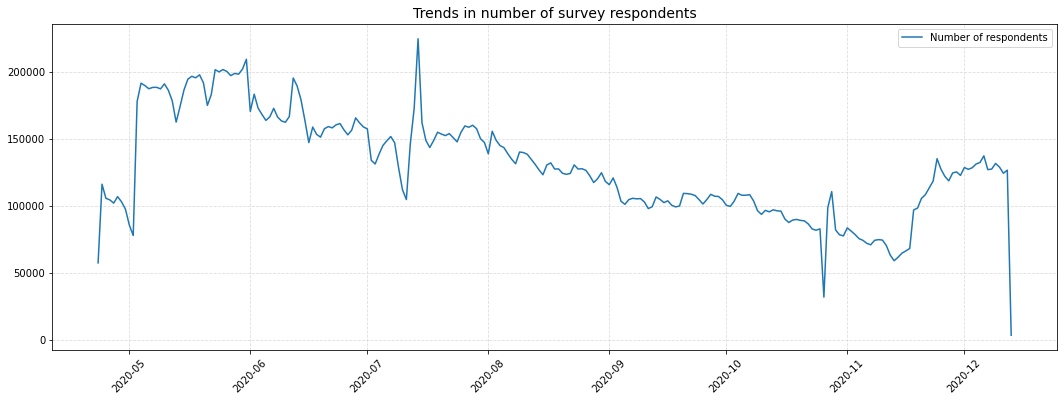

In [7]:
plt.figure(figsize=(18,6))
plt.plot(num_res.index, num_res.values, label='Number of respondents')
plt.xticks(rotation=45)
plt.legend()
plt.title('Trends in number of survey respondents', fontsize=14)
plt.grid(b=True, which='major', color='#DDD', linestyle='--')
plt.show()

Interest in the survey drops during the summer months but picks up again in November.

In [8]:
print(f'The top 10 countries or regions by sample size:\n{df.country_agg.value_counts()[:10]}')

The top 10 countries or regions by sample size:
Brazil       2729717
Mexico       2138084
Japan        1688976
India        1259113
Italy        1197364
Germany       922026
France        850395
Spain         766739
Argentina     750190
Colombia      658178
Name: country_agg, dtype: int64


***
#### Initial focus of EDA
According to the documentation there are three codebooks referring to specific timeframes of the survey. To keep this analysis brief, I will extract dates referred to by the first codebook until June 27, 2020.<br>
***

<a id="3"></a><br>
## <font color='#045FB4'>3. Basic quality check</font>

First, extract the relevant dataset till June 27, 2020.

In [10]:
enddate = pd.to_datetime("2020-06-27").date()
mask = (df['StartDate'] <= enddate)
fb = df.loc[mask]
print(f'Date range for trends dataset is from {fb.StartDate.min()} to {fb.StartDate.max()}')

Date range for trends dataset is from 2020-04-23 to 2020-06-27


In [11]:
gdf_stats(fb)

Total number of responses: 10944708
Total number of finished responses: 9939662
Range of dates is from 2020-04-23 to 2020-06-27
Number of unique country or regions: 243


<a id="4"></a><br>
### <font color='#045FB4'>Survey item response</font>

#### Check item missingness across dataset

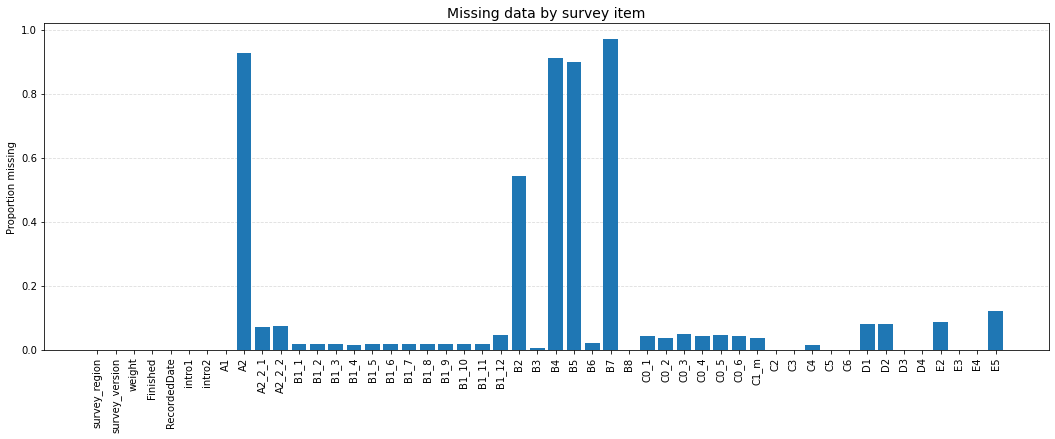

In [13]:
x = fb.loc[:, fb.columns[:50]].isna().sum().index
y = fb.loc[:, fb.columns[:50]].isna().sum().values / len(fb)
missing_data_plot(x, y)

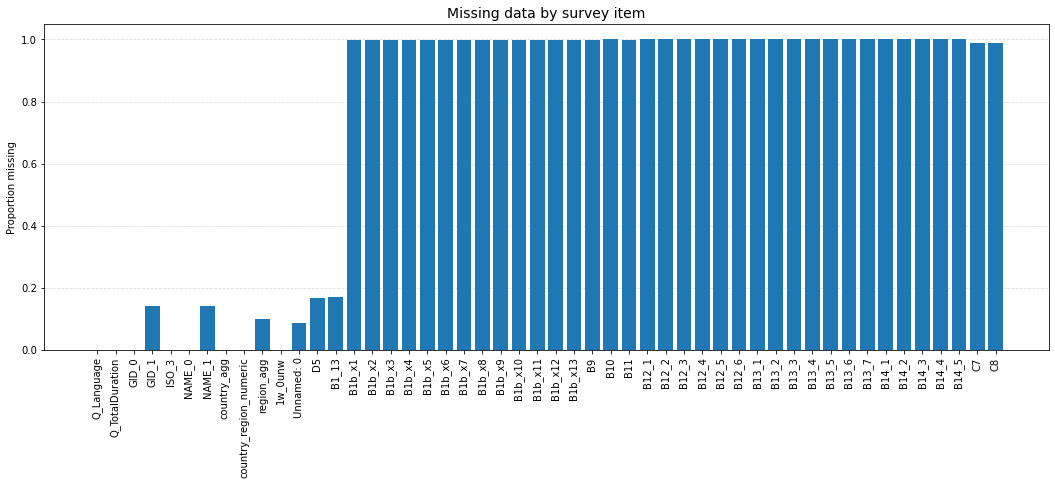

In [14]:
x = fb.loc[:, fb.columns[50:100]].isna().sum().index
y = fb.loc[:, fb.columns[50:100]].isna().sum().values / len(fb)
missing_data_plot(x, y)

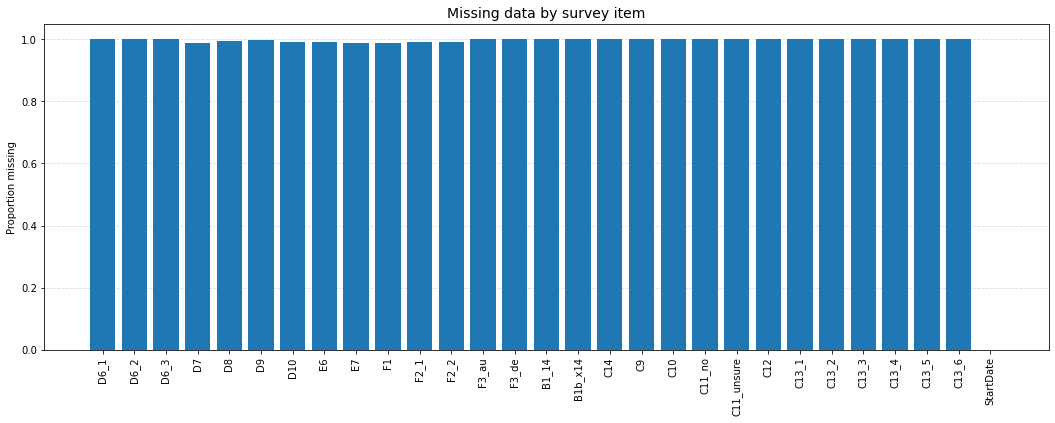

In [15]:
x = fb.loc[:, fb.columns[100:]].isna().sum().index
y = fb.loc[:, fb.columns[100:]].isna().sum().values / len(fb)
missing_data_plot(x, y)

Columns after **B1_13** do not appear to have any data (except for **StartDate**). Here, I will extract only those columns with data.

In [16]:
fb = fb.loc[:, fb.columns[:64]]
fb['RecordedDate'] = pd.to_datetime(fb['RecordedDate'], errors='coerce', utc=True)
fb['StartDate'] = fb['RecordedDate'].dt.date
gdf_stats(fb)

Total number of responses: 10944708
Total number of finished responses: 9939662
Range of dates is from 2020-04-23 to 2020-06-27
Number of unique country or regions: 243


**Note**: Some items have a coding of -99 which might relate to a non-response or missing data. This should be checked with the documentation or with the COVID-19 group.

#### Labeling variables
1. Using the Python defined **replace** function and user-defined dictionary **relabel_variables**.<br>
2. All **Yes/No** response items are re-labeled using the user-defined function **yesno_label**.
3. All other items with the same labeling such as **D3:D5** also replaced.

In [17]:
yesno_cols = ['A1', 'B1_1', 'B1_2', 'B1_3', 'B1_4', 'B1_5', 'B1_6', 'B1_7', 'B1_8', 'B1_9', 'B1_10', 'B1_11', 'B1_12',
                'B1_13', 'B3', 'B5', 'B6', 'B7', 'C0_1', 'C0_2', 'C0_3', 'C0_4', 'C0_5', 'C0_6', 'C1_m', 'C3']
fb = yesno_label(fb, yesno_cols)

In [18]:
worried_cols = ['D3', 'D4', 'D5']
fb = worried_label(fb, worried_cols)

In [19]:
fb = fb.replace(grelabel_variables)

<a id="5"></a><br>
### <font color='#045FB4'>Survey weights</font>

Weights should be applied as suggested in the official documentation for the survey [Weight and Methodology Brief for the COVID-19 Symptom Survey](https://covidmap.umd.edu/document/css_methods_brief.pdf).<br>
<blockquote>Survey weights are fairly straightforward to use and many types of analyses can be easilyadapted to work with a weighted sample.  We provide guidance for the three most commonestimators.  To the best of our knowledge, these estimators will fully address the needs in this initiative.</blockquote><br>

**Population mean** <br><br>
\begin{equation*}
\hat{y} = \frac {\sum \limits _{j \in S} w_j y_j}{\sum \limits _{j \in S} w_j}
\end{equation*}

**Population total** <br><br>
\begin{equation*}
\hat{t} = {\sum \limits _{j \in S} w_j y_j}
\end{equation*}

**Population ratio**<br><br>
\begin{equation*}
\hat{r} = \frac {\sum \limits _{j \in S} w_j y_j}{\sum \limits _{j \in S} w_j z_j}
\end{equation*}

For example, $y_{j}$= 1 if the respondent has qualifying COVID symptoms, in a geographical region $z_{j}$= 1 if the respondent is in the target region.

#### How much difference do weights make?

**Example: Item E3**<br>
<blockquote>What is your gender?</blockquote>

In [20]:
wtab(fb, "E3")

,Cat,Freq,Prop
0,Female,4959803,0.3807
1,Male,4965279,0.4960
2,NA,898927,0.1090
3,Prefer not to answer,95053,0.0113
4,Prefer to self describe,25646,0.0030


In [21]:
tab(fb, "E3")

,Cat,Freq,Prop
0,Female,4959803,0.4532
1,Male,4965279,0.4537
2,NA,898927,0.0821
3,Prefer not to answer,95053,0.0087
4,Prefer to self describe,25646,0.0023


- The unweighted and weighted tabulations show vastly different proportions for males and females
- Although, this is one example, it already indicates that weights will be important to consider

<a id="6"></a><br>
### <font color='#045FB4'>Continuous variables</font>

Continuous variables have a higher proportion of missing data. It is also important to check for the range of data. One example is shown here.<br>
<blockquote><b>E5</b> How many people slept in the place where you stayed last night?</blockquote><br>

In [22]:
wstats(fb, "E5")

Total number of observations: 9641375
Weighted Mean: 9.219524070880879e+184
Standard Deviation: inf
Maximum: 8.888888888888903e+191
Minimum: -9.0


- A small proportion of data is missing for item E5
- The maximum and minimum values are not possible
<br><br>
Let's reduce the maximum range value to something more feasible and check.

In [23]:
wstats(fb.loc[fb.E5 < 20], 'E5')

Total number of observations: 9609568
Weighted Mean: 2.837
Standard Deviation: 1.894
Maximum: 19.0
Minimum: -9.0


***
Any analysis using continuous variables should **perform further quality checks** on the variables and check for feasible ranges.
***

<a id="7"></a><br>
## <font color='#045FB4'>4. Tabulations</font>

Selected items will be tabulated for illustration and for getting a better understanding of the data. This won't be exhaustive of the entire survey but the analysis can be extended easily as needed.

<a id="8"></a><br>
### <font color='#045FB4'>Tabulation by item</font>

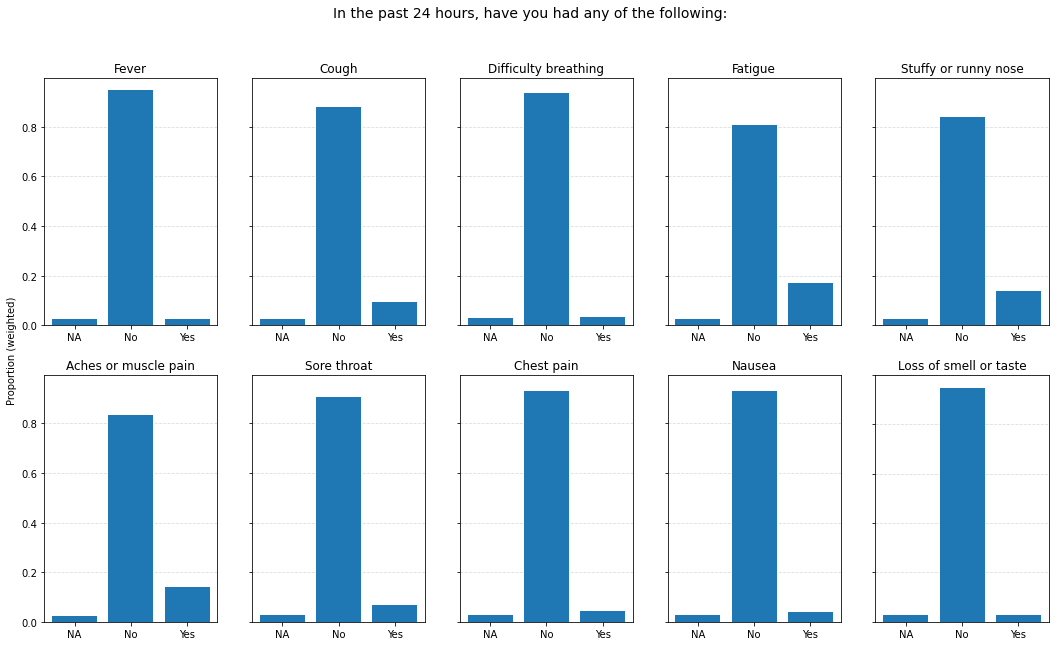

In [24]:
cols = ['B1_1', 'B1_2', 'B1_3', 'B1_4', 'B1_5', 'B1_6', 'B1_7', 'B1_8', 'B1_9', 'B1_10']
tls = ['Fever', 'Cough', 'Difficulty breathing', 'Fatigue', 'Stuffy or runny nose',
       'Aches or muscle pain', 'Sore throat', 'Chest pain', 'Nausea', 'Loss of smell or taste']
fig, ax = plt.subplots(2, 5, figsize=(18, 10), sharey=True)
ax = ax.flatten()
for i, x in enumerate(ax):
    x.bar(wtab(fb, cols[i])['Cat'], wtab(fb, cols[i])['Prop'])
    x.set_yticks(np.arange(0,1.1,0.2))
    x.set_title(tls[i])
    x.grid(which='major', axis='y', color='#DDD', linestyle='--')
plt.suptitle("In the past 24 hours, have you had any of the following:", fontsize=14)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel('Proportion (weighted)')
plt.show()

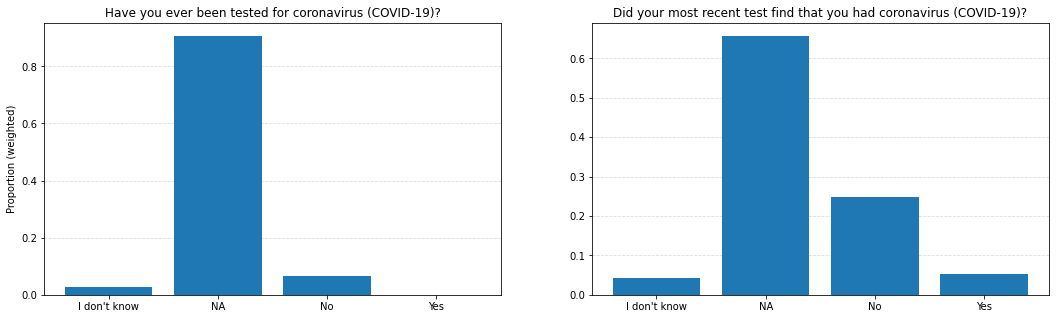

In [25]:
b6 = wtab(fb, 'B6')
fb.loc[fb.B8==-99, 'B8'] = "NA"
b8 = wtab(fb.loc[fb.B6=="Yes"], 'B8')
fig, ax = plt.subplots(1, 2, figsize=(18, 5), sharex=True)
ax[0].bar(b6['Cat'], b6['Prop'])
ax[0].set_title('Have you ever been tested for coronavirus (COVID-19)?')
ax[0].grid(which='major', axis='y', color='#DDD', linestyle='--')
ax[1].bar(b8['Cat'], b8['Prop'])
ax[1].set_title('Did your most recent test find that you had coronavirus (COVID-19)?')
ax[1].grid(which='major', axis='y', color='#DDD', linestyle='--')
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel('Proportion (weighted)')
plt.show()

The right graph was filtered for those who reported ever testing for COVID-19.

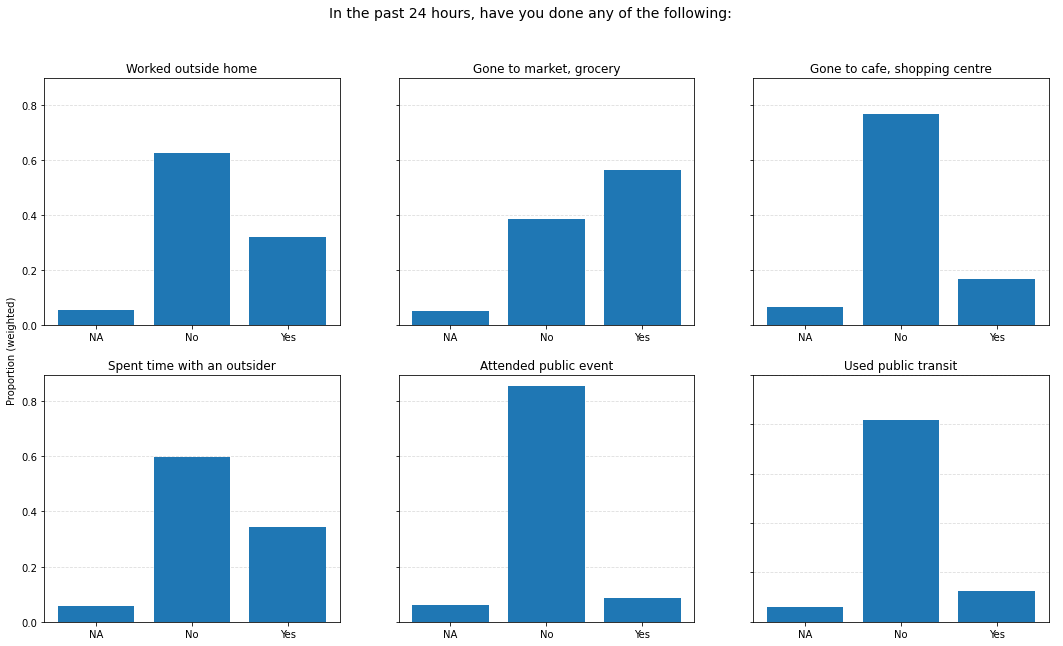

In [26]:
cols = ['C0_1', 'C0_2', 'C0_3', 'C0_4', 'C0_5', 'C0_6']
tls = ['Worked outside home', 'Gone to market, grocery', 'Gone to cafe, shopping centre', 'Spent time with an outsider', 
       'Attended public event', 'Used public transit']
fig, ax = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
ax = ax.flatten()
for i, x in enumerate(ax):
    x.bar(wtab(fb, cols[i])['Cat'], wtab(fb, cols[i])['Prop'])
    x.set_yticks(np.arange(0,1.1,0.2))
    x.set_title(tls[i])
    x.grid(which='major', axis='y', color='#DDD', linestyle='--')
plt.suptitle("In the past 24 hours, have you done any of the following:", fontsize=14)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel('Proportion (weighted)')
plt.show()

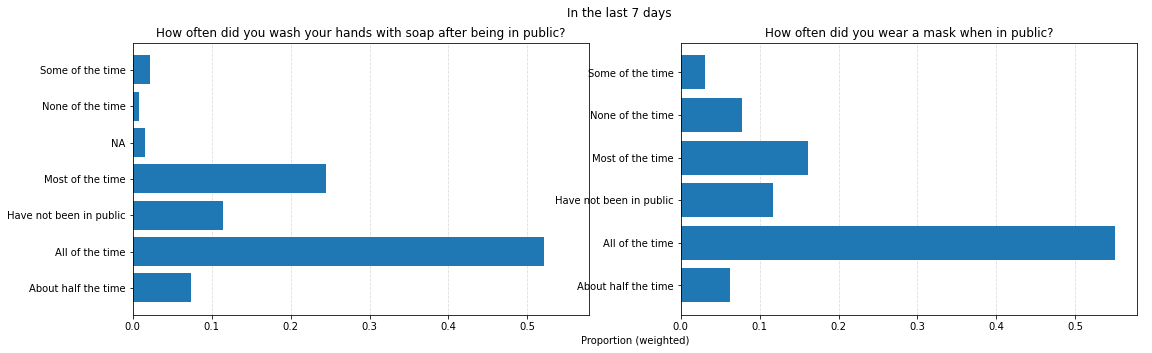

In [27]:
c4 = wtab(fb.loc[fb.C4!="NA"], 'C4')
c5 = wtab(fb.loc[fb.C5!="NA"], 'C5')
fig, ax = plt.subplots(1, 2, figsize=(18, 5), sharex=True)
ax[0].barh(c4['Cat'], c4['Prop'])
ax[0].set_title('How often did you wash your hands with soap after being in public?')
ax[0].grid(which='major', axis='x', color='#DDD', linestyle='--')
ax[1].barh(c5['Cat'], c5['Prop'])
ax[1].set_title('How often did you wear a mask when in public?')
ax[1].grid(which='major', axis='x', color='#DDD', linestyle='--')
plt.suptitle('In the last 7 days')
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Proportion (weighted)')
plt.show()

The '-99' coded values were removed before the proportions were calculated

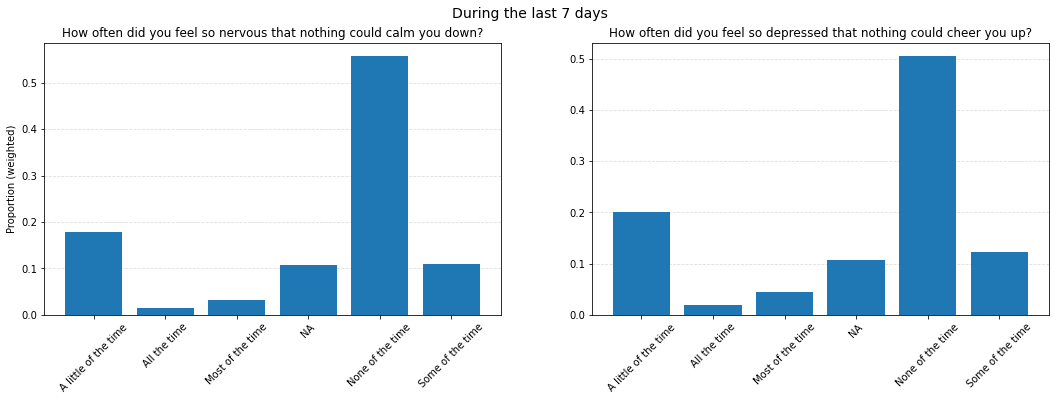

In [28]:
d1 = wtab(fb, 'D1')
d2 = wtab(fb, 'D2')
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
ax[0].bar(d1['Cat'], d1['Prop'])
ax[0].set_title('How often did you feel so nervous that nothing could calm you down?')
ax[0].grid(which='major', axis='y', color='#DDD', linestyle='--')
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
ax[1].bar(d2['Cat'], d2['Prop'])
ax[1].set_title('How often did you feel so depressed that nothing could cheer you up?')
ax[1].grid(which='major', axis='y', color='#DDD', linestyle='--')
for tick in ax[1].get_xticklabels():
    tick.set_rotation(45)
plt.suptitle('During the last 7 days', fontsize=14)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel('Proportion (weighted)')
plt.show()

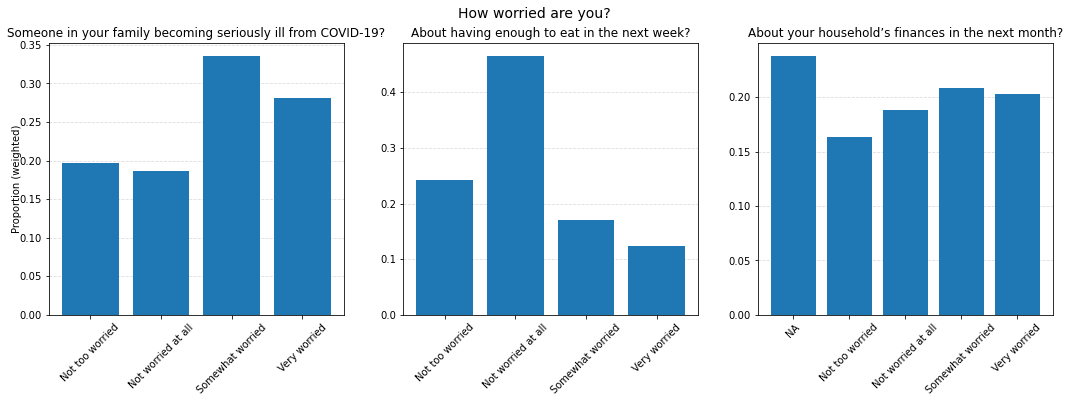

In [29]:
d3 = wtab(fb.loc[fb.D3!=-99], 'D3')
d4 = wtab(fb.loc[fb.D4!=-99], 'D4')
d5 = wtab(fb.loc[fb.D5!=-99], 'D5')
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].bar(d3['Cat'], d3['Prop'])
ax[0].set_title('Someone in your family becoming seriously ill from COVID-19?')
ax[0].grid(which='major', axis='y', color='#DDD', linestyle='--')
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
ax[1].bar(d4['Cat'], d4['Prop'])
ax[1].set_title('About having enough to eat in the next week?')
ax[1].grid(which='major', axis='y', color='#DDD', linestyle='--')
for tick in ax[1].get_xticklabels():
    tick.set_rotation(45)
ax[2].bar(d5['Cat'], d5['Prop'])
ax[2].set_title('About your household’s finances in the next month?')
ax[2].grid(which='major', axis='y', color='#DDD', linestyle='--')
for tick in ax[2].get_xticklabels():
    tick.set_rotation(45)
plt.suptitle('How worried are you?', fontsize=14)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel('Proportion (weighted)')
plt.show()

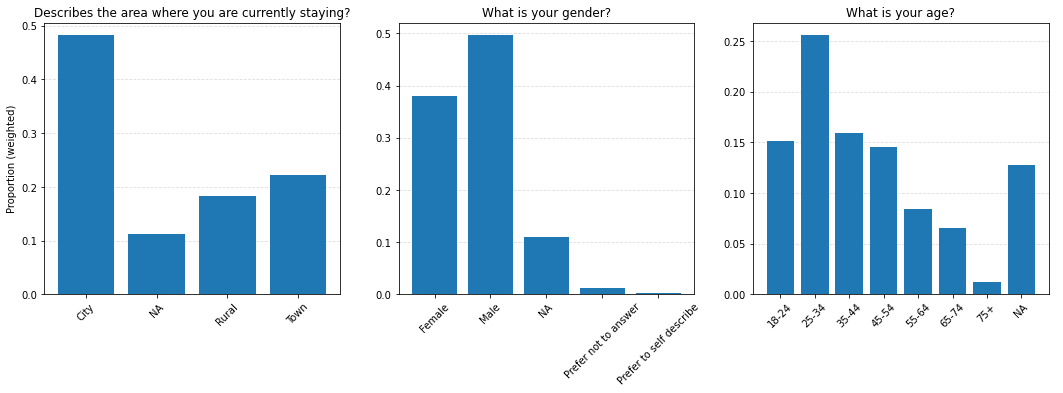

In [30]:
e2 = wtab(fb, 'E2')
e3 = wtab(fb, 'E3')
e4 = wtab(fb, 'E4')
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].bar(e2['Cat'], e2['Prop'])
ax[0].set_title('Describes the area where you are currently staying?')
ax[0].grid(which='major', axis='y', color='#DDD', linestyle='--')
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
ax[1].bar(e3['Cat'], e3['Prop'])
ax[1].set_title('What is your gender?')
ax[1].grid(which='major', axis='y', color='#DDD', linestyle='--')
for tick in ax[1].get_xticklabels():
    tick.set_rotation(45)
ax[2].bar(e4['Cat'], e4['Prop'])
ax[2].set_title('What is your age?')
ax[2].grid(which='major', axis='y', color='#DDD', linestyle='--')
for tick in ax[2].get_xticklabels():
    tick.set_rotation(45)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel('Proportion (weighted)')
plt.show()

<a id="9"></a><br>
### <font color='#045FB4'>Cross tabulations</font>

The focus will be on some cross tabulations with gender and age.

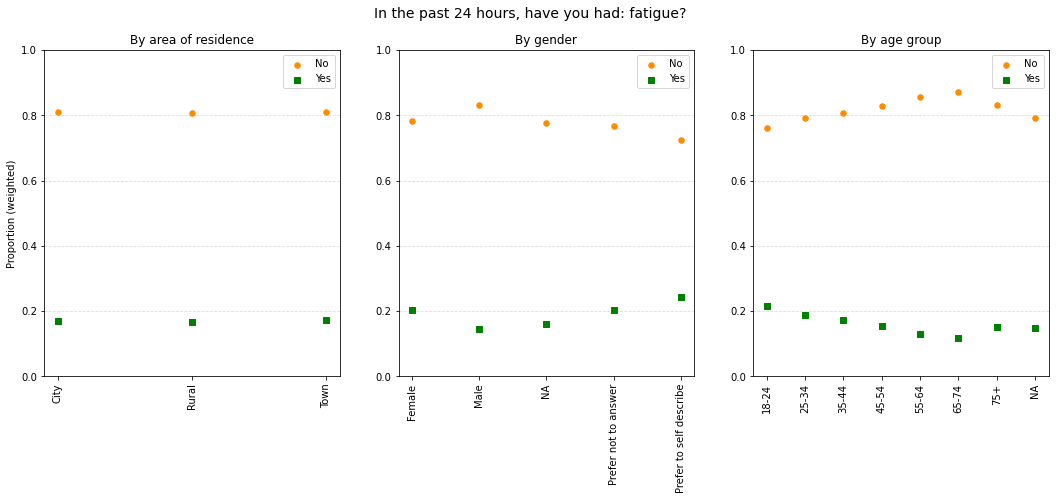

In [36]:
d = gwcrosstab(fb, 'E2', 'B1_4')
g = gwcrosstab(fb, 'E3', 'B1_4')
a = gwcrosstab(fb, 'E4', 'B1_4')
suptitle = 'In the past 24 hours, have you had: fatigue?'
cross_plot_3(d, g, a, 'B1_4', suptitle)

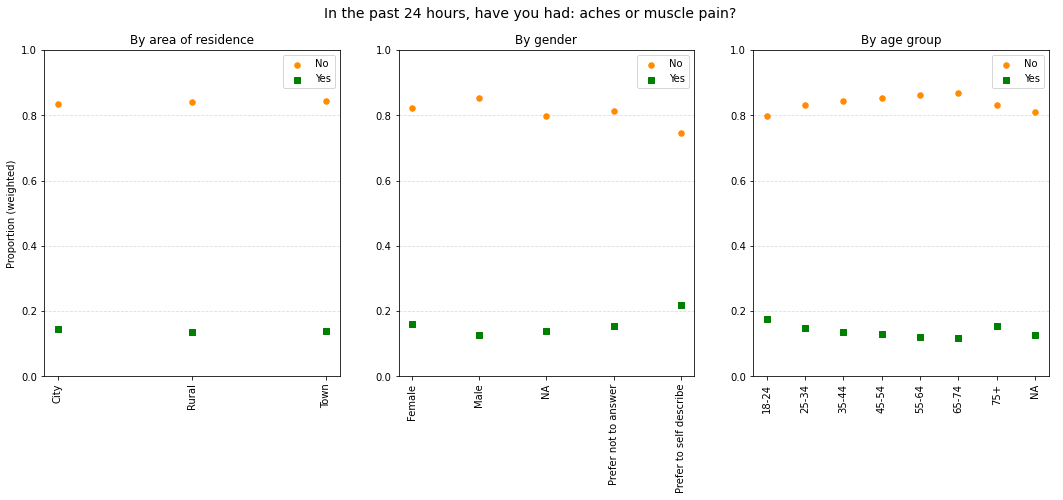

In [37]:
d = gwcrosstab(fb, 'E2', 'B1_6')
g = gwcrosstab(fb, 'E3', 'B1_6')
a = gwcrosstab(fb, 'E4', 'B1_6')
suptitle = 'In the past 24 hours, have you had: aches or muscle pain?'
cross_plot_3(d, g, a, 'B1_6', suptitle)

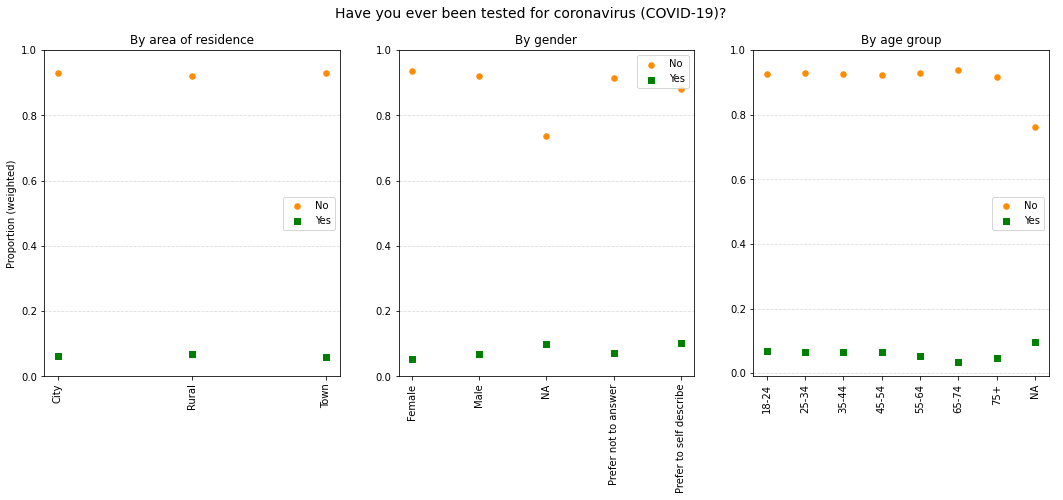

In [38]:
d = gwcrosstab(fb, 'E2', 'B6')
g = gwcrosstab(fb, 'E3', 'B6')
a = gwcrosstab(fb, 'E4', 'B6')
suptitle = 'Have you ever been tested for coronavirus (COVID-19)?'
cross_plot_3(d, g, a, 'B6', suptitle)

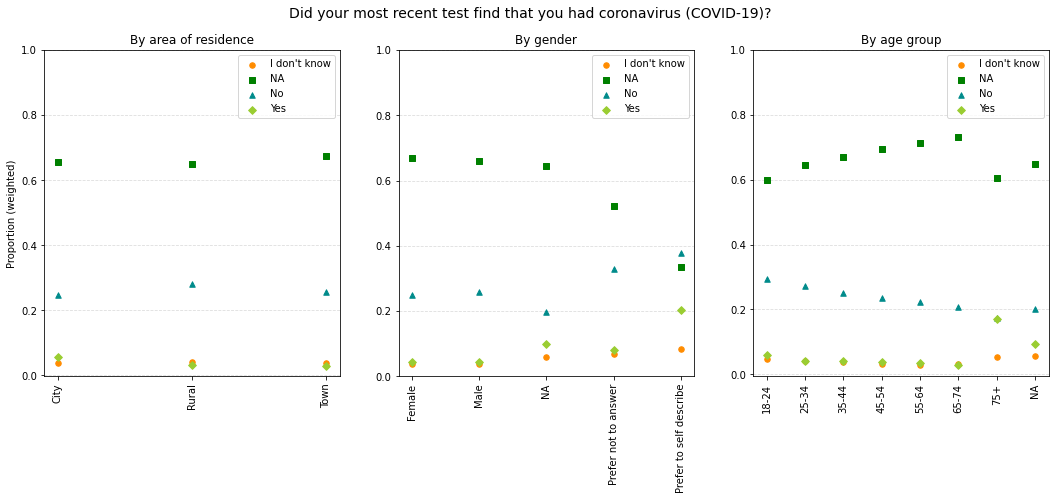

In [39]:
d = gwcrosstab(fb.loc[fb.B6=="Yes"], 'E2', 'B8')
g = gwcrosstab(fb.loc[fb.B6=="Yes"], 'E3', 'B8')
a = gwcrosstab(fb.loc[fb.B6=="Yes"], 'E4', 'B8')
suptitle = 'Did your most recent test find that you had coronavirus (COVID-19)?'
cross_plot_3(d, g, a, 'B8', suptitle)

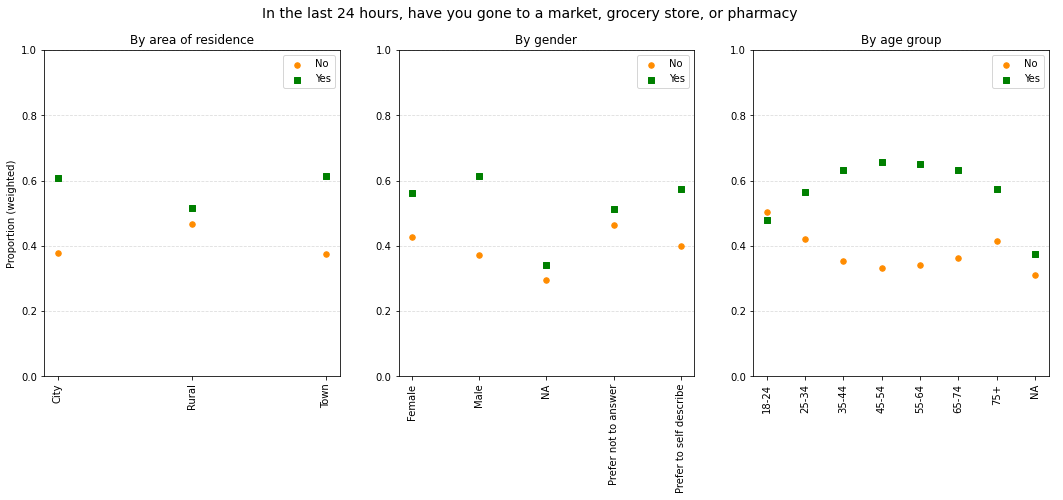

In [40]:
d = gwcrosstab(fb, 'E2', 'C0_2')
g = gwcrosstab(fb, 'E3', 'C0_2')
a = gwcrosstab(fb, 'E4', 'C0_2')
suptitle = 'In the last 24 hours, have you gone to a market, grocery store, or pharmacy'
cross_plot_3(d, g, a, 'C0_2', suptitle)

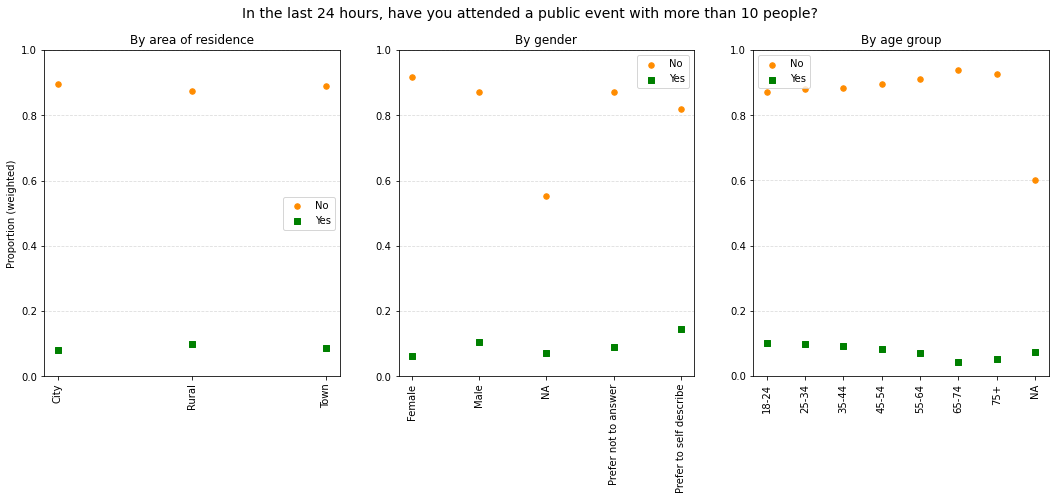

In [41]:
col = 'C0_5'
d = gwcrosstab(fb, 'E2', col)
g = gwcrosstab(fb, 'E3', col)
a = gwcrosstab(fb, 'E4', col)
suptitle = 'In the last 24 hours, have you attended a public event with more than 10 people?'
cross_plot_3(d, g, a, col, suptitle)

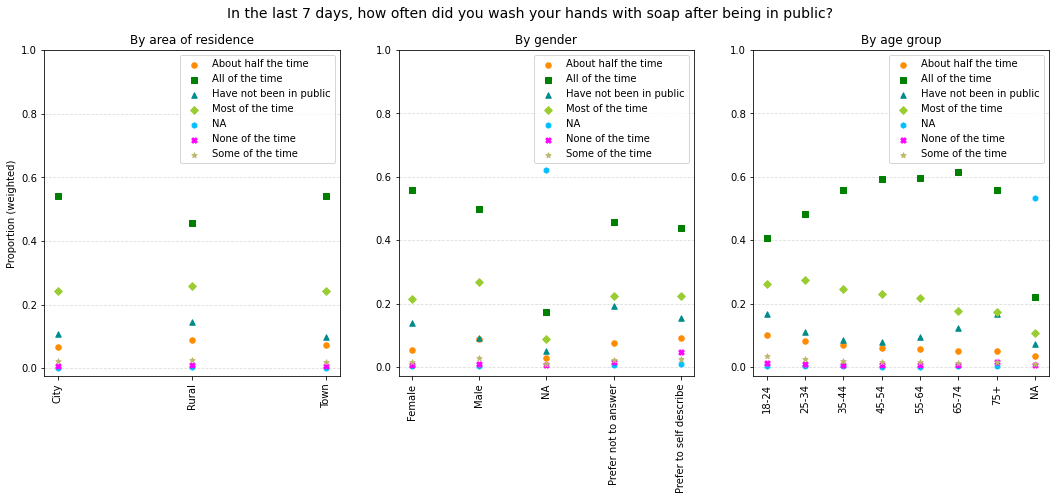

In [42]:
col = 'C4'
d = gwcrosstab(fb, 'E2', col)
g = gwcrosstab(fb, 'E3', col)
a = gwcrosstab(fb, 'E4', col)
suptitle = 'In the last 7 days, how often did you wash your hands with soap after being in public?'
cross_plot_3(d, g, a, col, suptitle)

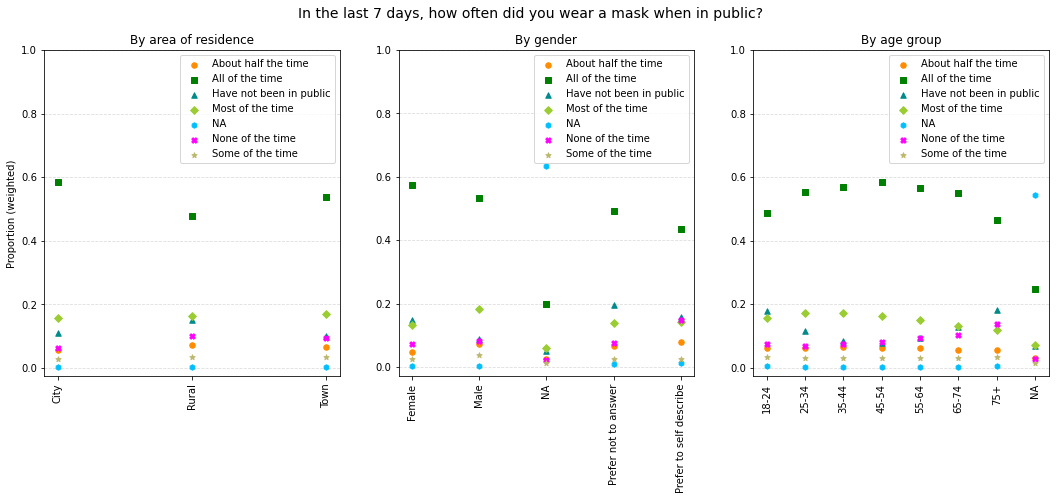

In [43]:
col = 'C5'
d = gwcrosstab(fb, 'E2', col)
g = gwcrosstab(fb, 'E3', col)
a = gwcrosstab(fb, 'E4', col)
suptitle = 'In the last 7 days, how often did you wear a mask when in public?'
cross_plot_3(d, g, a, col, suptitle)

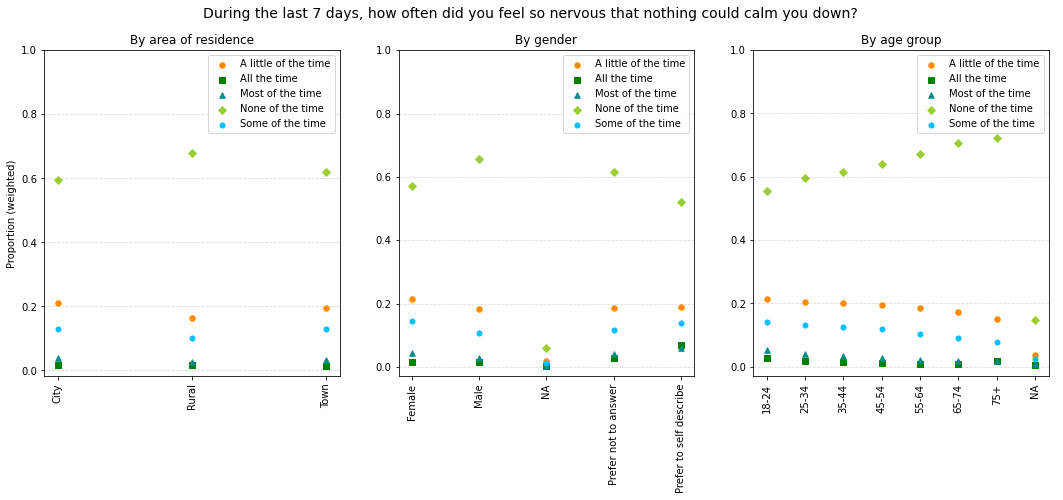

In [44]:
col = 'D1'
d = gwcrosstab(fb, 'E2', col)
g = gwcrosstab(fb, 'E3', col)
a = gwcrosstab(fb, 'E4', col)
suptitle = 'During the last 7 days, how often did you feel so nervous that nothing could calm you down?'
cross_plot_3(d, g, a, col, suptitle)

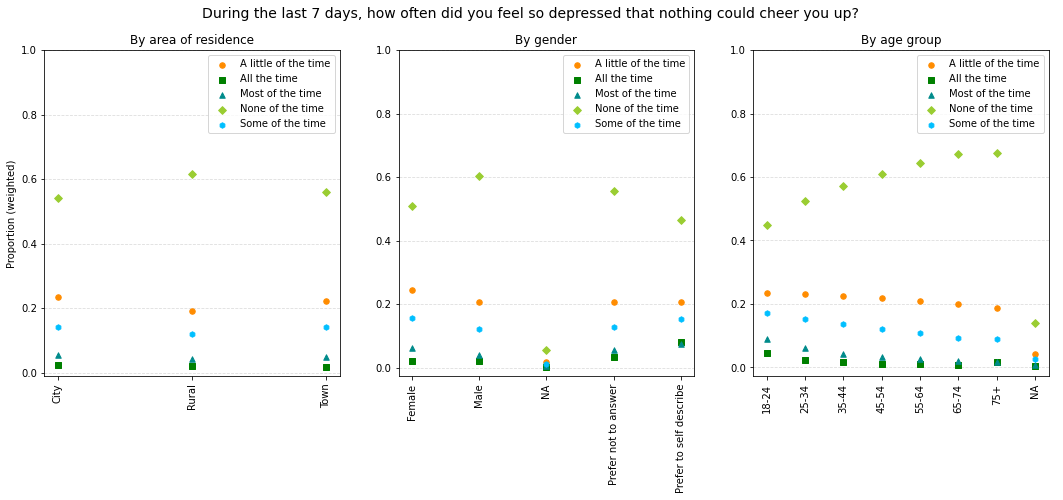

In [45]:
col = 'D2'
d = gwcrosstab(fb, 'E2', col)
g = gwcrosstab(fb, 'E3', col)
a = gwcrosstab(fb, 'E4', col)
suptitle = 'During the last 7 days, how often did you feel so depressed that nothing could cheer you up?'
cross_plot_3(d, g, a, col, suptitle)

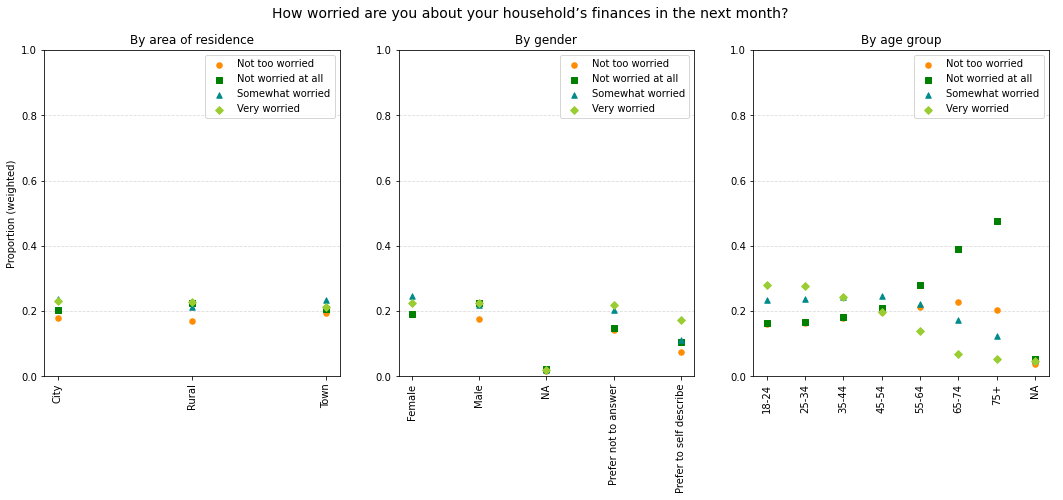

In [46]:
col = 'D5'
d = gwcrosstab(fb, 'E2', col)
g = gwcrosstab(fb, 'E3', col)
a = gwcrosstab(fb, 'E4', col)
suptitle = 'How worried are you about your household’s finances in the next month?'
cross_plot_3(d, g, a, col, suptitle)

#### Cross-tabulations by selected countries

In [47]:
top_countries = fb.country_agg.value_counts().index[:6].to_list()
fbc = fb.loc[fb.country_agg.isin(top_countries)]
gdf_stats(fbc)

Total number of responses: 3330124
Total number of finished responses: 3041140
Range of dates is from 2020-04-23 to 2020-06-27
Number of unique country or regions: 6


In [48]:
cols = ['B1_4', 'B1_5', 'B1_6']
d = gwcrosstab(fbc, 'country_agg', cols[0])
g = gwcrosstab(fbc, 'country_agg', cols[1])
a = gwcrosstab(fbc, 'country_agg', cols[2])
frames = [d, g, a]

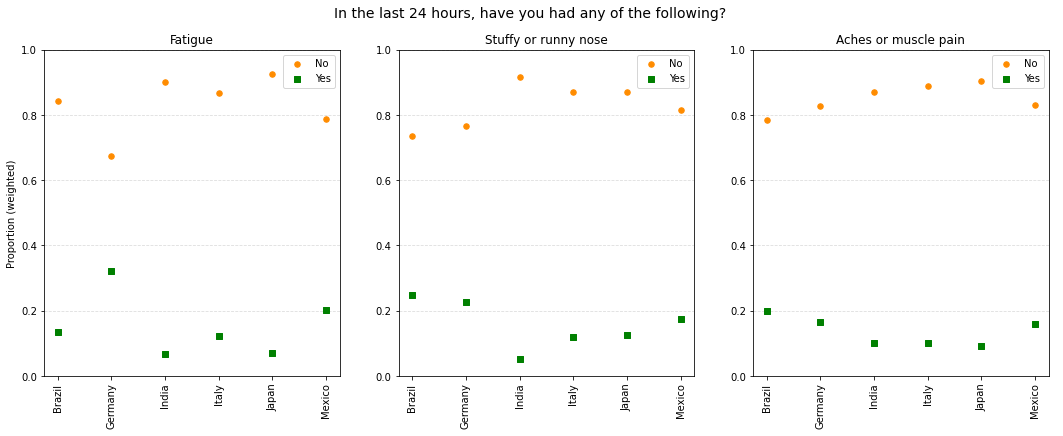

In [49]:
labels = ['Fatigue', 'Stuffy or runny nose', 'Aches or muscle pain']
fig, ax = plt.subplots(1, 3, figsize=(18,6))
ax = ax.flatten()
for i, x in enumerate(ax):
    for j, resp in enumerate(frames[i][cols[i]].unique()):
        x.scatter(frames[i].loc[frames[i][cols[i]]==resp, 'country_agg'], frames[i].loc[frames[i][cols[i]]==resp, 'Prop'], label=resp, marker=markers[j], c=colors[j], s=30)
    x.legend()
    x.grid(which='major', axis='y', color='#DDD', linestyle='--')
    x.set_yticks(np.arange(0,1.1,0.2))
    x.set_title(labels[i])
    for tick in x.get_xticklabels():
        tick.set_rotation(90)
plt.suptitle("In the last 24 hours, have you had any of the following?", fontsize=14)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel('Proportion (weighted)')
plt.show()

In [50]:
cols = ['C0_1', 'C0_2', 'C0_6']
d = gwcrosstab(fbc, 'country_agg', cols[0])
g = gwcrosstab(fbc, 'country_agg', cols[1])
a = gwcrosstab(fbc, 'country_agg', cols[2])
frames = [d, g, a]

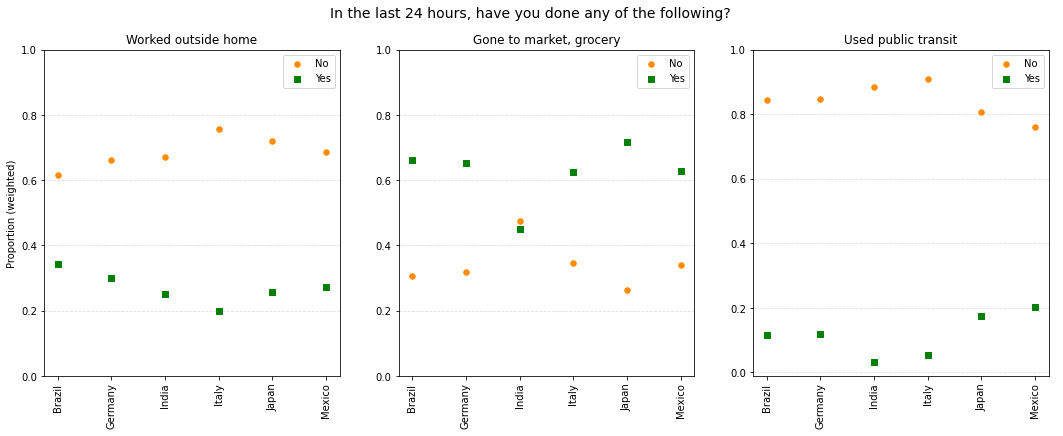

In [51]:
labels = ['Worked outside home', 'Gone to market, grocery', 'Used public transit']
fig, ax = plt.subplots(1, 3, figsize=(18,6))
ax = ax.flatten()
for i, x in enumerate(ax):
    for j, resp in enumerate(frames[i][cols[i]].unique()):
        x.scatter(frames[i].loc[frames[i][cols[i]]==resp, 'country_agg'], frames[i].loc[frames[i][cols[i]]==resp, 'Prop'], label=resp, marker=markers[j], c=colors[j], s=30)
    x.legend()
    x.grid(which='major', axis='y', color='#DDD', linestyle='--')
    x.set_yticks(np.arange(0,1.1,0.2))
    x.set_title(labels[i])
    for tick in x.get_xticklabels():
        tick.set_rotation(90)
plt.suptitle("In the last 24 hours, have you done any of the following?", fontsize=14)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel('Proportion (weighted)')
plt.show()

In [52]:
cols = ['C4', 'C5']
d = gwcrosstab(fbc, 'country_agg', cols[0])
g = gwcrosstab(fbc, 'country_agg', cols[1])
frames = [d, g]

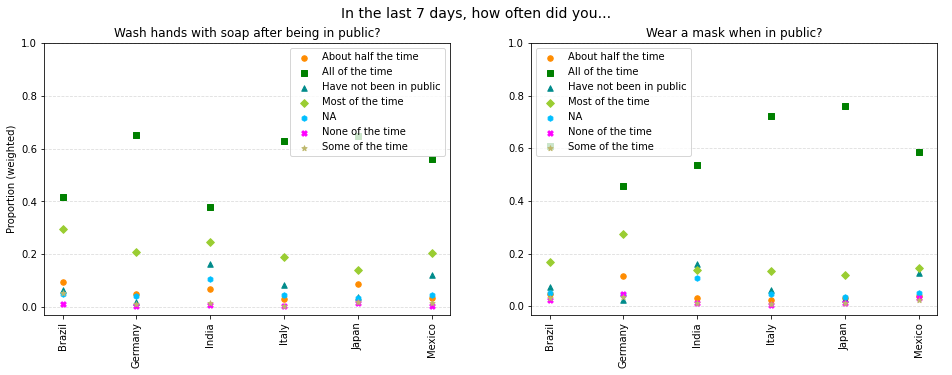

In [53]:
labels = ['Wash hands with soap after being in public?', 'Wear a mask when in public?']
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax = ax.flatten()
for i, x in enumerate(ax):
    for j, resp in enumerate(frames[i][cols[i]].unique()):
        x.scatter(frames[i].loc[frames[i][cols[i]]==resp, 'country_agg'], frames[i].loc[frames[i][cols[i]]==resp, 'Prop'], label=resp, marker=markers[j], c=colors[j], s=30)
    x.legend()
    x.grid(which='major', axis='y', color='#DDD', linestyle='--')
    x.set_yticks(np.arange(0,1.1,0.2))
    x.set_title(labels[i])
    for tick in x.get_xticklabels():
        tick.set_rotation(90)
plt.suptitle("In the last 7 days, how often did you...", fontsize=14)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel('Proportion (weighted)')
plt.show()

<a id="10"></a><br>
## <font color='#045FB4'>5. Trends</font>

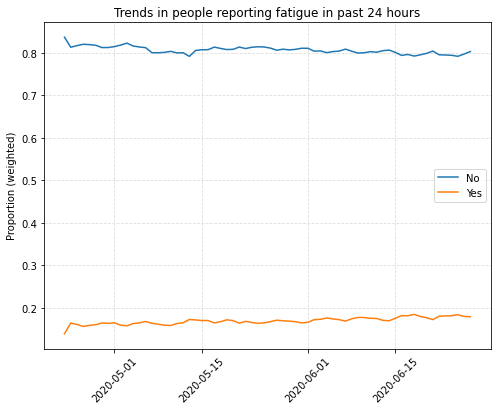

In [57]:
col='B1_4'
col_labels = fb[col].value_counts().sort_index().index.to_list()
title = 'Trends in people reporting fatigue in past 24 hours'
trends_plot(fb, col, 'Prop', col_labels, title)

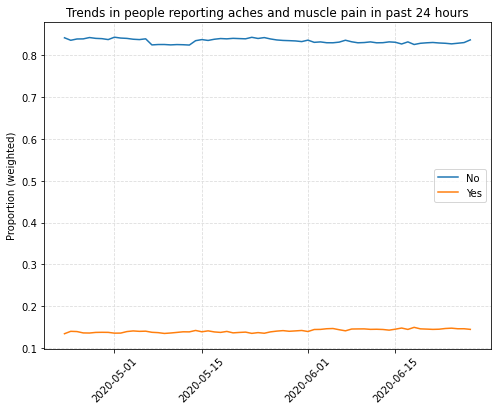

In [58]:
col='B1_6'
col_labels = fb[col].value_counts().sort_index().index.to_list()
title = 'Trends in people reporting aches and muscle pain in past 24 hours'
trends_plot(fb, col, 'Prop', col_labels, title)

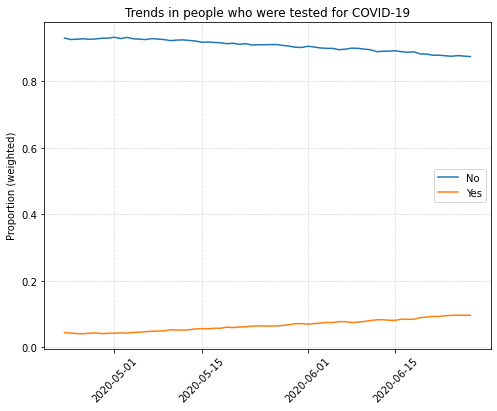

In [59]:
col='B6'
col_labels = fb[col].value_counts().sort_index().index.to_list()
title = 'Trends in people who were tested for COVID-19'
trends_plot(fb, col, 'Prop', col_labels, title)

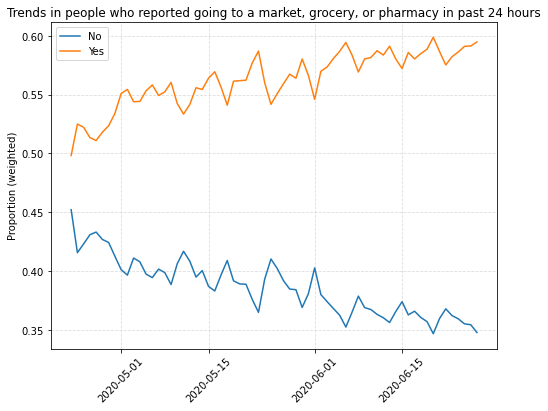

In [60]:
col='C0_2'
col_labels = fb[col].value_counts().sort_index().index.to_list()
title = 'Trends in people who reported going to a market, grocery, or pharmacy in past 24 hours'
trends_plot(fb, col, 'Prop', col_labels, title)

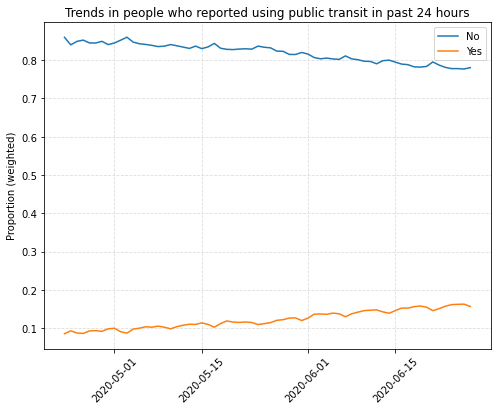

In [61]:
col='C0_6'
col_labels = fb[col].value_counts().sort_index().index.to_list()
title = 'Trends in people who reported using public transit in past 24 hours'
trends_plot(fb, col, 'Prop', col_labels, title)

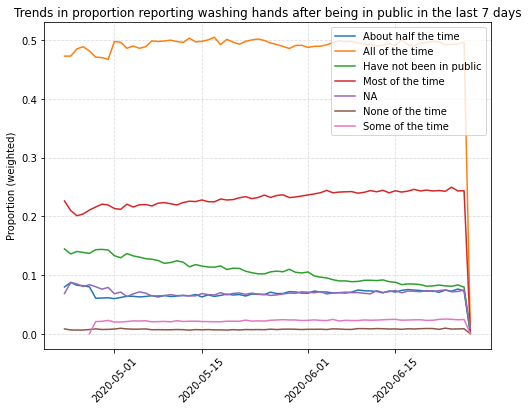

In [62]:
col='C4'
col_labels = fb[col].value_counts().sort_index().index.to_list()
title = 'Trends in proportion reporting washing hands after being in public in the last 7 days'
trends_plot(fb, col, 'Prop', col_labels, title)

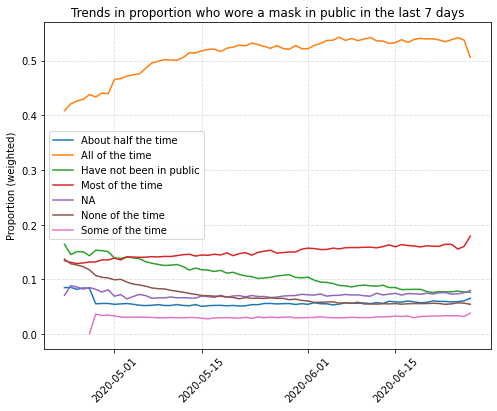

In [63]:
col='C5'
col_labels = fb[col].value_counts().sort_index().index.to_list()
title = 'Trends in proportion who wore a mask in public in the last 7 days'
trends_plot(fb, col, 'Prop', col_labels, title)

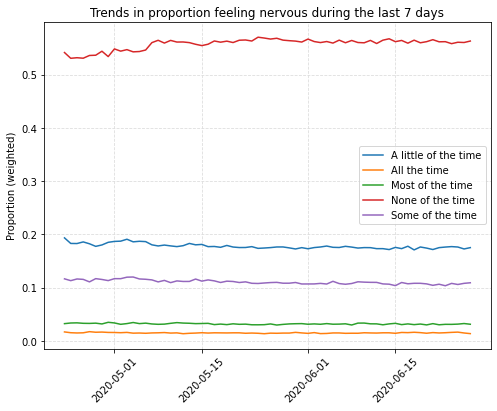

In [65]:
col='D1'
col_labels = fb[col].value_counts().sort_index().index.to_list()
title = "Trends in proportion feeling nervous during the last 7 days"
trends_plot(fb, col, 'Prop', col_labels, title)

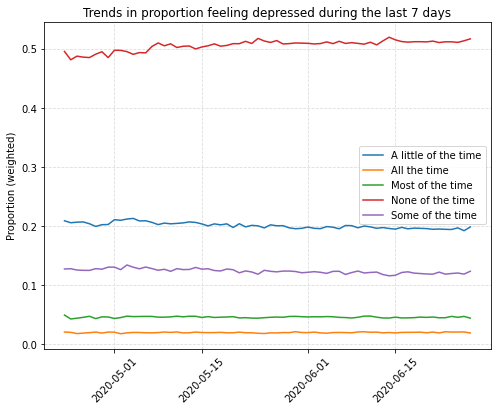

In [66]:
col='D2'
col_labels = fb[col].value_counts().sort_index().index.to_list()
title = "Trends in proportion feeling depressed during the last 7 days"
trends_plot(fb, col, 'Prop', col_labels, title)

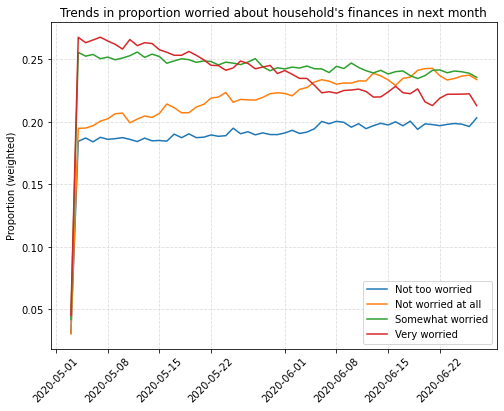

In [64]:
col='D5'
col_labels = fb[col].value_counts().sort_index().index.to_list()
title = "Trends in proportion worried about household's finances in next month"
trends_plot(fb, col, 'Prop', col_labels, title)

#### Trends in items by gender and age

The analysis in this section is restricted to using **Yes/No** response items. All graphs are stratified by gender and age groups as specified in the survey instrument.

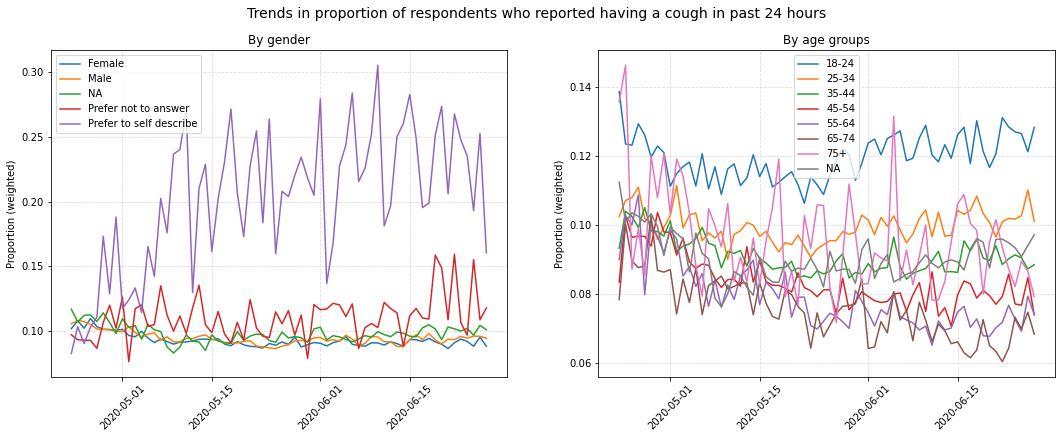

In [71]:
col1='E3'
col2='B1_2'
col3='E4'
title = "Trends in proportion of respondents who reported having a cough in past 24 hours"
gcross_trends_plot(fb, col1, col2, col3, title)

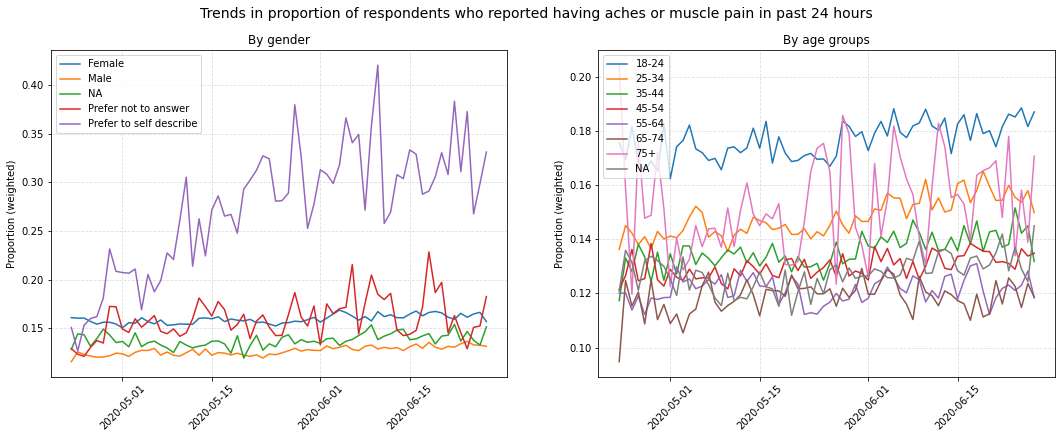

In [72]:
col1='E3'
col2='B1_6'
col3='E4'
title = "Trends in proportion of respondents who reported having aches or muscle pain in past 24 hours"
gcross_trends_plot(fb, col1, col2, col3, title)

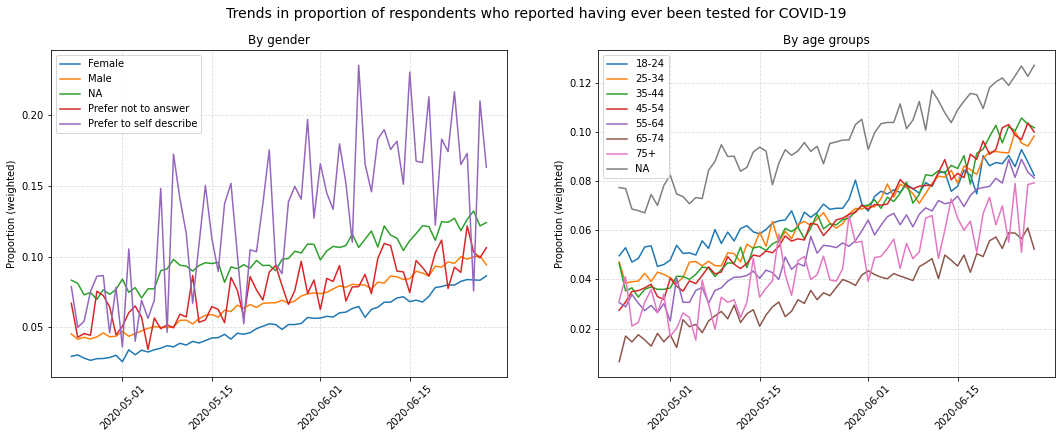

In [75]:
col1='E3'
col2='B6'
col3='E4'
title = "Trends in proportion of respondents who reported having ever been tested for COVID-19"
gcross_trends_plot(fb, col1, col2, col3, title)

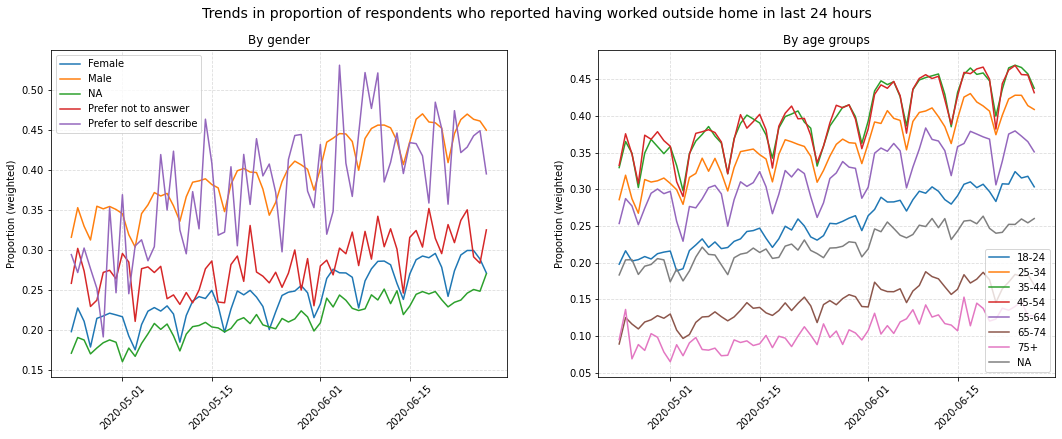

In [74]:
col1='E3'
col2='C0_1'
col3='E4'
title = "Trends in proportion of respondents who reported having worked outside home in last 24 hours"
gcross_trends_plot(fb, col1, col2, col3, title)

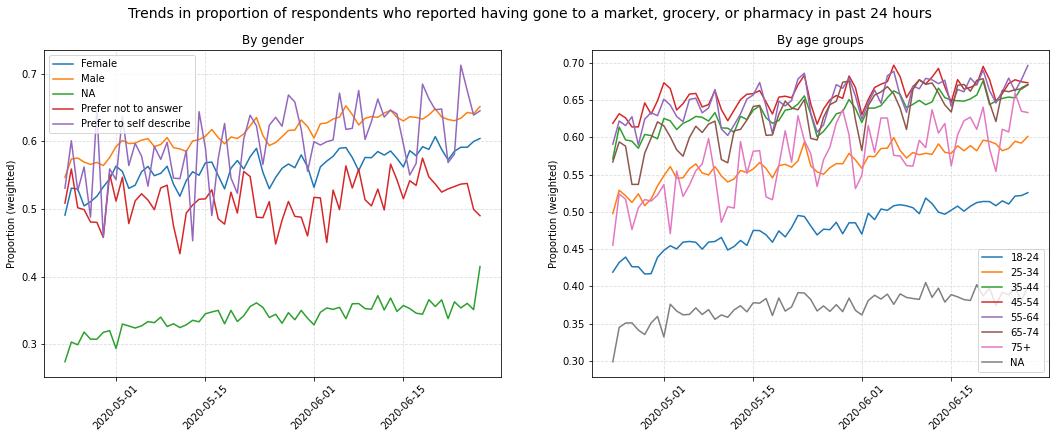

In [76]:
col1='E3'
col2='C0_2'
col3='E4'
title = "Trends in proportion of respondents who reported having gone to a market, grocery, or pharmacy in past 24 hours"
gcross_trends_plot(fb, col1, col2, col3, title)

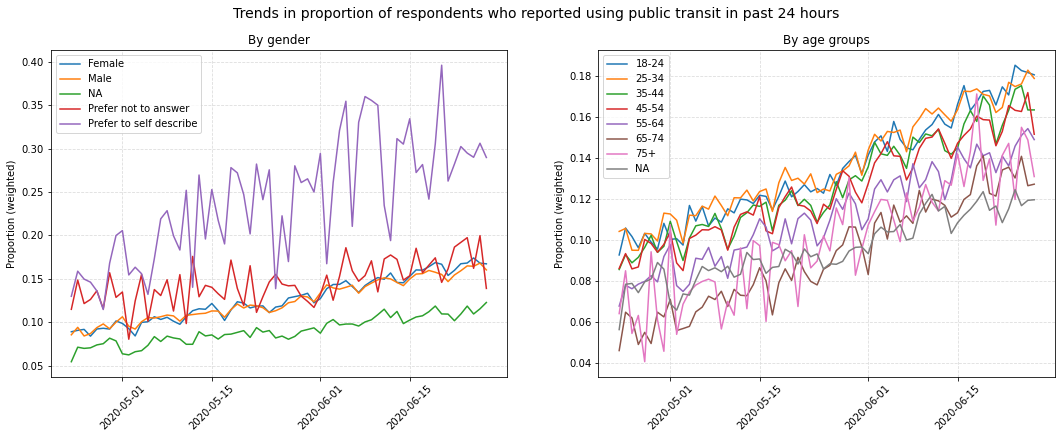

In [77]:
col1='E3'
col2='C0_6'
col3='E4'
title = "Trends in proportion of respondents who reported using public transit in past 24 hours"
gcross_trends_plot(fb, col1, col2, col3, title)

#### Trends in items by selected countries

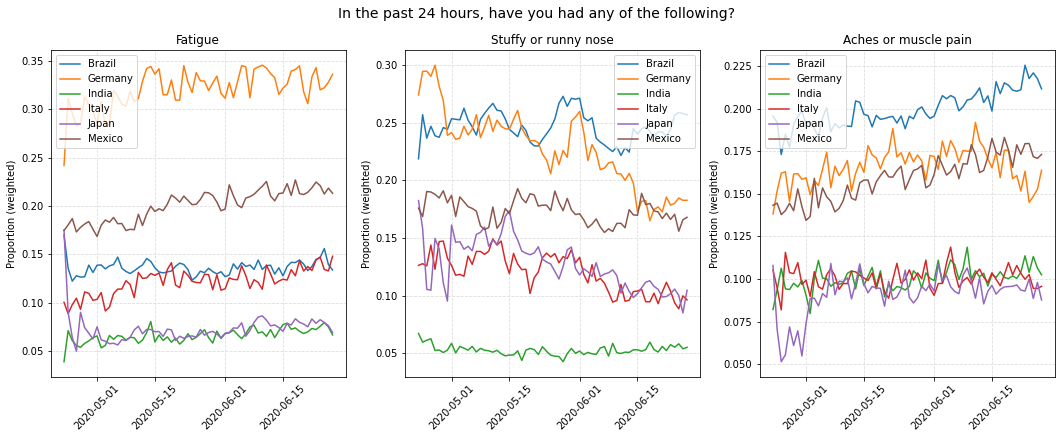

In [89]:
col1 = 'country_agg'
cols = ['B1_4', 'B1_5', 'B1_6']
labels = ['Fatigue', 'Stuffy or runny nose', 'Aches or muscle pain']
fig, ax = plt.subplots(1, 3, figsize=(18,6))
ax = ax.flatten()
for i, x in enumerate(ax):
    q = fbc.groupby([col1, cols[i], 'StartDate']).count()
    val = wcrosstab_by_date(fbc, col1, cols[i])
    val['Freq'] = pd.Series(q['survey_region'].values)
    val = val.loc[val[cols[i]] == "Yes"]
    a = val[col1].value_counts().sort_index().index
    for j in range(len(a)):
        x.plot(val.loc[val[col1]==a[j], 'StartDate'], val.loc[val[col1]==a[j], 'Prop'], label=a[j])
    x.set_title(labels[i])
    x.legend()
    x.set_ylabel('Proportion (weighted)')
    x.grid(b=True,which='major', color='#DDD', linestyle='--')
    for tick in x.get_xticklabels():
        tick.set_rotation(45)
plt.suptitle('In the past 24 hours, have you had any of the following?', fontsize=14)
plt.show()

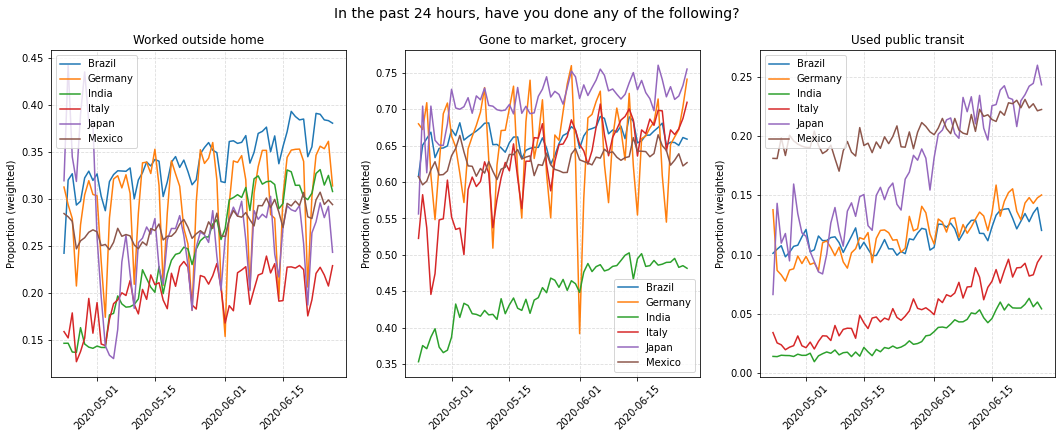

In [90]:
col1 = 'country_agg'
cols = ['C0_1', 'C0_2', 'C0_6']
labels = ['Worked outside home', 'Gone to market, grocery', 'Used public transit']
fig, ax = plt.subplots(1, 3, figsize=(18,6))
ax = ax.flatten()
for i, x in enumerate(ax):
    q = fbc.groupby([col1, cols[i], 'StartDate']).count()
    val = wcrosstab_by_date(fbc, col1, cols[i])
    val['Freq'] = pd.Series(q['survey_region'].values)
    val = val.loc[val[cols[i]] == "Yes"]
    a = val[col1].value_counts().sort_index().index
    for j in range(len(a)):
        x.plot(val.loc[val[col1]==a[j], 'StartDate'], val.loc[val[col1]==a[j], 'Prop'], label=a[j])
    x.set_title(labels[i])
    x.legend()
    x.set_ylabel('Proportion (weighted)')
    x.grid(b=True,which='major', color='#DDD', linestyle='--')
    for tick in x.get_xticklabels():
        tick.set_rotation(45)
plt.suptitle('In the past 24 hours, have you done any of the following?', fontsize=14)
plt.show()

<a id="11"></a><br>
## <font color='#045FB4'>6. Key messages</font>

#### Limitations
- Analyzed dataset for the timeframe specified by first of three codebooks till June 27, 2020. This contained nearly one-third of the total number of respondents to date.
- Selected survey items were analyzed to understand the dataset. A more comprehensive analysis should follow.
- Correcting errors in code and optimization of code might be needed.
- Messages inferred from this initial EDA will need to be refined with a comprehensive analysis of the dataset.

***
#### Key messages
- Number of daily survey respondents decreased over time but interest picked up again in November. 
- Continuous numeric response items have higher missing rates and have infeasible ranges of data. Therefore, any analysis using continuous variables should carefully check for quality.
- Survey weights are important and should be applied as instructed in the documentation.
- Fewer proportion of respondents have reported symptoms over time. A higher proportion have become outside their homes over time as well.
- Results differ by country on many key issues such as the frequency of hand washing and wearing of masks in public.
***